In [61]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd, ipywidgets as wdg, matplotlib.ticker as ticker
from sklearn.metrics import r2_score #true, pred
from itertools import product
from functools import partial
from hypercube.box import Box_Plant
wave = np.load('./hypercube/wave.npy')

dct_train = {1: 'C5', 3:'C11', 6:'C9', 8:'C5', 12:'C10', 19:'C5', 25:'C8'} # (для 1 и 3 не C а A)
dct_test = {1: 'C8', 3: 'C8', 6: 'C8', 8: 'C8', 12: 'C8', 19: 'C4', 25: 'C10'}

O = lambda x: np.around(x, 2) # Округление
RMSE = lambda y1, y2: O(((y1 - y2)**2).mean()**(.5))
PLCC = lambda y1, y2: O(np.corrcoef(y1, y2)[0, 1])
Path = lambda dct, day: f'Data/1_90/{day}/{dct[day]}' # Путь к данным
Formula = lambda x, y: y.mean() + (x - x.mean()) * y.std() / x.std() # Формула связи

def Preprocessing(day, dct, thr, n=143, a=2, b=2):
    pot = Box_Plant(path=Path(dct, day))
    pot.Wheat(thr); mask_w = pot.Mask()
    pot.LR_Deviation(pot.Channel([n]), a, b)
    mask_ab = pot.Mask()
    return pot, mask_w, mask_ab

class Table:
    def __init__(self):
        
        self.table = pd.DataFrame(columns=['Day', 'Threshold', 'a', 'b', 'Mask (pix)', 'PLCC', 'RMSE', 'Chan, No/ Wavelength',
                    'Max Chan.', 'Min Chan.', 'Mean Chan.', 'Std Chan.','Max TIR', 'Min TIR', 'Mean TIR', 'Std TIR'])
        
    def Append(self, day, dct, thr, n, a, b, link, mode=0):
        pot, mask_w, mask_ab = Preprocessing(day=day, dct=dct, thr=thr, n=n, a=a, b=b)
        mask = mask_ab if not mode else mask_w if mode == 1 else mask_w ^ mask_ab
        
        band_m = pot.Channel([n])[mask]
        tir_m = pot.TIR()[mask]; lpix = len(tir_m); pred = link(x=band_m); rmse = RMSE(pred, tir_m); plcc = PLCC(band_m, tir_m)
        
        self.table.loc[len(self.table)] = [day, thr, a, b, lpix, plcc, rmse, f'{n}/{np.around(wave[n]).astype(int)}',
               O(band_m.max()), O(band_m.min()), O(band_m.mean()), O(band_m.std()),
               O(tir_m.max()), O(tir_m.min()), O(tir_m.mean()), O(tir_m.std())]
        
    def Save(self, path='table 1'):
        self.table.to_excel(f'{path}.xlsx')

### Графики зависимостей

Каналы HSI имеют разную корреляцию с TIR, которая также варьируется от порога (thr). Выявление наиболее коррелированных каналов позволит использовать их для предсказания температуры.

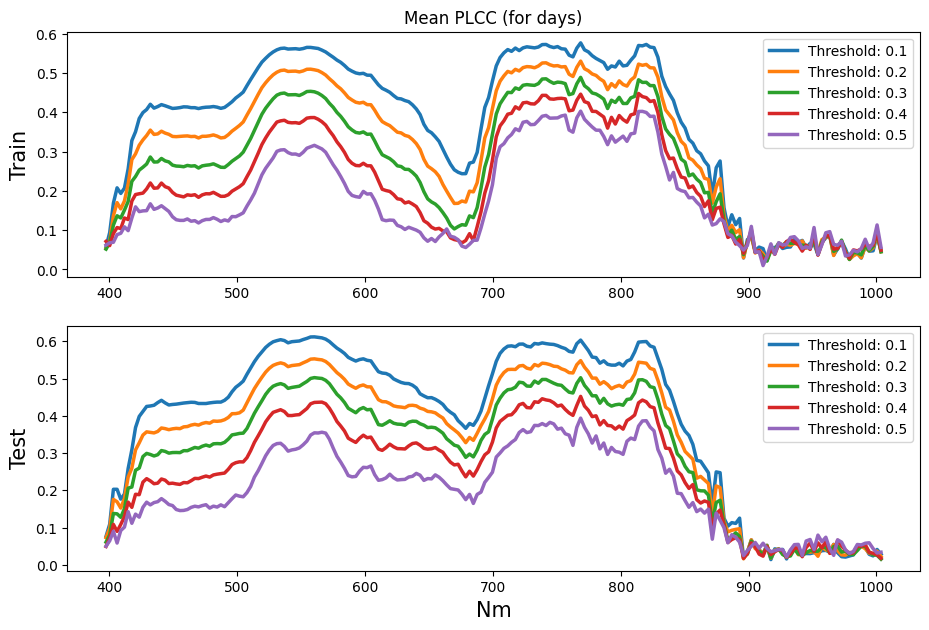

In [132]:
def Mean_PLCC(dct):
    plcc_dct = {thr: np.zeros(204) for thr in [.1, .2, .3, .4, .5]}
    for day, thr in product(dct, plcc_dct):
        pot = Box_Plant(path=Path(dct, day)); pot.Wheat(thr)
        corr_lst = list(pot.Correlation_Indx(indx_func=0, sort=False).values())
        plcc_dct[thr] += np.abs(corr_lst) / len(dct)
    return plcc_dct

plcc_train = Mean_PLCC(dct_train)
plcc_test = Mean_PLCC(dct_test)

fig, ax = plt.subplots(2, figsize=(11, 7))
for thr in plcc_train:
    ax[0].plot(wave, plcc_train[thr], linewidth=2.5, label=f'Threshold: {thr}')
    ax[1].plot(wave, plcc_test[thr], linewidth=2.5, label=f'Threshold: {thr}')

ax[0].set_title('Mean PLCC (for days)'); ax[1].set_xlabel('Nm', fontsize=15)
ax[0].set_ylabel('Train', fontsize=15); ax[1].set_ylabel('Test', fontsize=15)
ax[0].legend(); ax[1].legend(); plt.show()

Корреляция зависит и от рассматриваемого дня.

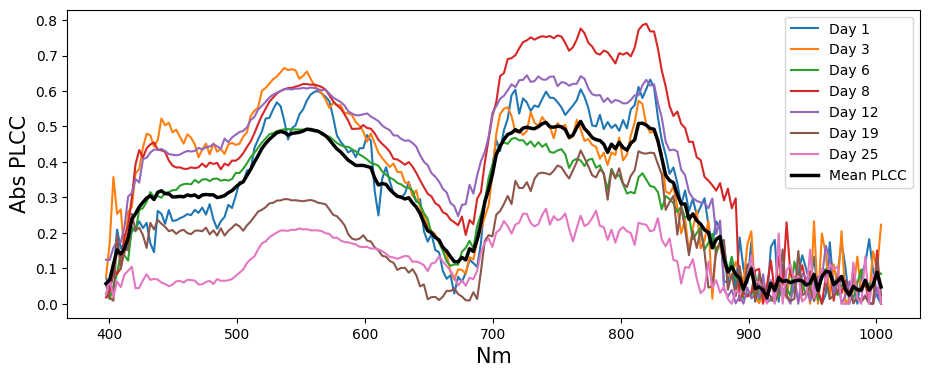

In [152]:
dct = dct_train; mean_plcc = np.zeros(204)
fig, ax = plt.subplots(figsize=(11, 4))
for day in dct:
    pot = Box_Plant(path=Path(dct, day)); pot.Wheat(.3, channel=pot.Channel([142], [54], func=lambda b1, b2: b1 - b2))
    
    # Корреляция по каналам
    abs_plcc = np.abs(list(pot.Correlation_Indx(indx_func=0, sort=False).values()))
    ax.plot(wave, abs_plcc, label=f'Day {day}', linewidth=1.5)
    
    mean_plcc += abs_plcc

ax.plot(wave, mean_plcc/len(dct), color='black', label='Mean PLCC', linewidth=2.5)
ax.set_xlabel('Nm', fontsize=15); ax.set_ylabel('Abs PLCC', fontsize=15); ax.legend(); plt.show()

### Построение таблиц

In [62]:
#--------[_______day 1_______] [________day 3________] [___________day 6_____________] Выбранные пороги (a, b) для
ABLst = [.1, .1, .1, .08, .06, .1, .08, .06, .05, .04, .08, .07, .05, (.05, .04), .04, # всех дней при thr от 0.1 до 0.5
#---------[______day 8______] [_____day 12______] [_______day 19_________] [_______________day 25_______________] 
          .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .04, .04, .04, .05, .05, .04, .03, (.03, .02), (.02, .01), .01] # 25

def Table_Create(ab_lst, mode=0, save_flag=False):
    # mode: (0 - Mask_THR & Mask_AB; 1 - Mask_THR, 2 - Mask_THR \ Mask_AB)
    tab = Table()
    for i, (day, thr) in enumerate(product((1, 3, 6, 8, 12, 19, 25), (.1, .2, .3, .4, .5))):
        ab = ab_lst[i]; a, b = (ab[0], ab[1]) if type(ab) == tuple else (ab, ab)
        
        pot, mask_w, mask_ab = Preprocessing(day=day, dct=dct_train, thr=thr, a=a, b=b)
        
        mask = mask_ab if not mode else mask_w if mode == 1 else mask_w ^ mask_ab # маска зависит от режима
        
        tir_m = pot.TIR()[mask]; link = partial(Formula, y=tir_m)
        
        tab.Append(day=day, dct=dct_test, thr=thr, n=143, a=a, b=b, link=link, mode=mode)
        
    if mode == 1:
        del tab.table['a']; del tab.table['b']
    display(tab.table)
    if save_flag: tab.Save(path='table')

# Построение таблицы при выбранных (Thr, a, b), где (a,b) указаны в ABLst
Table_Create(ab_lst=ABLst, mode=0)

,Day,Threshold,a,b,Mask (pix),PLCC,RMSE,"Chan, No/ Wavelength",Max Chan.,Min Chan.,Mean Chan.,Std Chan.,Max TIR,Min TIR,Mean TIR,Std TIR
0,1,0.1,0.10,0.10,1243,0.95,0.14,143/820,1.37,0.05,0.55,0.29,21.38,20.45,20.82,0.17
1,1,0.2,0.10,0.10,1110,0.93,0.09,143/820,1.21,0.11,0.59,0.27,21.25,20.49,20.85,0.15
2,1,0.3,0.10,0.10,888,0.90,0.08,143/820,1.21,0.16,0.67,0.24,21.25,20.58,20.90,0.13
3,1,0.4,0.08,0.08,556,0.91,0.06,143/820,1.21,0.26,0.76,0.20,21.25,20.65,20.95,0.11
4,1,0.5,0.06,0.06,316,0.92,0.05,143/820,1.21,0.37,0.81,0.16,21.23,20.77,20.99,0.09
5,3,0.1,0.10,0.10,1207,0.92,0.19,143/820,1.42,0.05,0.50,0.32,21.29,20.60,20.87,0.14
6,3,0.2,0.08,0.08,735,0.90,0.20,143/820,1.42,0.11,0.60,0.28,21.23,20.70,20.93,0.10
7,3,0.3,0.06,0.06,447,0.82,0.20,143/820,1.37,0.16,0.66,0.22,21.16,20.78,20.96,0.06
8,3,0.4,0.05,0.05,284,0.64,0.20,143/820,1.32,0.32,0.74,0.18,21.08,20.91,21.00,0.04
9,3,0.5,0.04,0.04,141,0.63,0.17,143/820,1.26,0.47,0.82,0.16,21.11,20.96,21.04,0.03


In [4]:
# Построение таблицы без учета величин (a,b)
Table_Create(ab_lst=ABLst, mode=1)

,Day,Threshold,Mask (pix),PLCC,RMSE,"Chan, No/ Wavelength",Max Chan.,Min Chan.,Mean Chan.,Std Chan.,Max TIR,Min TIR,Mean TIR,Std TIR
0,1,0.1,2534,0.75,0.21,143/820,1.37,0.05,0.53,0.29,21.50,20.17,20.81,0.23
1,1,0.2,2159,0.70,0.19,143/820,1.37,0.05,0.59,0.27,21.50,20.27,20.85,0.21
2,1,0.3,1702,0.63,0.19,143/820,1.37,0.16,0.67,0.24,21.50,20.38,20.90,0.19
3,1,0.4,1274,0.60,0.18,143/820,1.37,0.21,0.74,0.21,21.50,20.45,20.95,0.18
4,1,0.5,867,0.56,0.17,143/820,1.37,0.32,0.82,0.19,21.50,20.52,21.00,0.16
5,3,0.1,2744,0.52,0.28,143/820,1.42,0.05,0.49,0.30,21.50,20.07,20.87,0.23
6,3,0.2,2156,0.41,0.28,143/820,1.42,0.05,0.58,0.27,21.50,20.10,20.92,0.21
7,3,0.3,1643,0.29,0.29,143/820,1.42,0.16,0.67,0.24,21.50,20.10,20.96,0.19
8,3,0.4,1134,0.18,0.29,143/820,1.42,0.26,0.77,0.21,21.50,20.31,21.00,0.18
9,3,0.5,700,0.17,0.26,143/820,1.42,0.42,0.86,0.19,21.49,20.52,21.04,0.16


In [9]:
# Маска, построенная только по Thr содержит больше пикселей, чем маска по (Thr, a, b)
# Данная таблица строится по маске Thr с вычетом маски (Thr, a, b)
Table_Create(ab_lst=ABLst, mode=2)

,Day,Threshold,a,b,Mask (pix),PLCC,RMSE,"Chan, No/ Wavelength",Max Chan.,Min Chan.,Mean Chan.,Std Chan.,Max TIR,Min TIR,Mean TIR,Std TIR
0,1,0.1,0.10,0.10,1291,0.65,0.26,143/820,1.32,0.05,0.51,0.29,21.50,20.17,20.79,0.27
1,1,0.2,0.10,0.10,1049,0.59,0.26,143/820,1.37,0.05,0.59,0.27,21.50,20.27,20.85,0.25
2,1,0.3,0.10,0.10,814,0.52,0.26,143/820,1.37,0.16,0.67,0.24,21.50,20.38,20.90,0.24
3,1,0.4,0.08,0.08,718,0.52,0.23,143/820,1.37,0.21,0.74,0.23,21.50,20.45,20.94,0.22
4,1,0.5,0.06,0.06,551,0.51,0.20,143/820,1.37,0.32,0.83,0.20,21.50,20.52,21.01,0.19
5,3,0.1,0.10,0.10,1537,0.38,0.35,143/820,1.37,0.05,0.48,0.28,21.50,20.07,20.86,0.27
6,3,0.2,0.08,0.08,1421,0.34,0.32,143/820,1.37,0.05,0.57,0.27,21.50,20.10,20.91,0.25
7,3,0.3,0.06,0.06,1196,0.26,0.32,143/820,1.42,0.16,0.67,0.25,21.50,20.10,20.96,0.22
8,3,0.4,0.05,0.05,850,0.16,0.32,143/820,1.42,0.26,0.78,0.22,21.50,20.31,21.01,0.20
9,3,0.5,0.04,0.04,559,0.16,0.29,143/820,1.42,0.42,0.87,0.20,21.49,20.52,21.04,0.18


### Предсказание по формуле связи

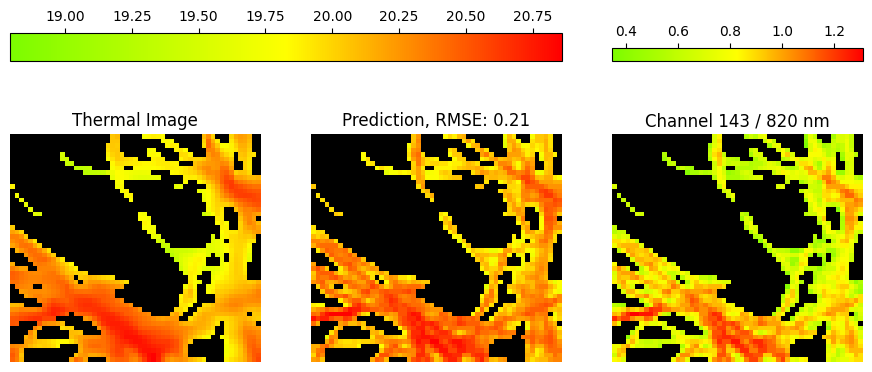

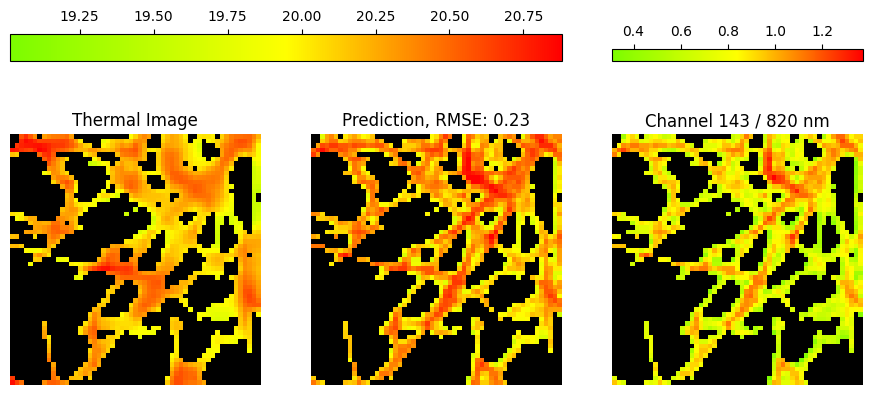

In [86]:
def Prediction(day, train, test, thr=.4, n=143, a=2, b=2):
    process = partial(Preprocessing, day=day, thr=thr, n=n, a=a, b=b)
    pot, mask_w, mask_ab = process(dct=train); tir = pot.TIR(); link = partial(Formula, y=tir)

    pot, mask_w, mask_ab = process(dct=test, thr=thr); channel = pot.Channel([n]); tir = pot.TIR()
    pred = link(x=channel); rmse = RMSE(pred[mask_ab], tir[mask_ab])
    
    fig, ax = plt.subplots(1, 3, figsize=(11, 19))
    plot = partial(pot.Plot, fig=fig, cbar=False); min_t, max_t = tir.min(), tir.max()
    t = plot(tir, ax=ax[0], min_t=min_t, max_t=max_t); ax[0].set_title('Thermal Image')
    plot(pred, ax=ax[1], min_t=min_t, max_t=max_t); ax[1].set_title(f'Prediction, RMSE: {rmse}')
    c = plot(channel, ax=ax[2]); ax[2].set_title(f'Channel {n} / {np.around(wave[n]).astype(int)} nm')
    cbar = partial(plt.colorbar, location='top', orientation='horizontal'); cbar(t, ax=ax[:-1]); cbar(c, ax=ax[-1])
    
    return pred, rmse

Prediction(day=8, train=dct_train, test=dct_train, thr=.4, n=143, a=2, b=2)
Prediction(day=8, train=dct_train, test=dct_test, thr=.4, n=143, a=2, b=2)
pass